# Cuts on the z and sz

I think we can set a threshold on the SNR for each detection

In [1]:
from astropy.io import fits
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
from importlib import reload
from utils import ks2_utils, shared_utils, image_utils

In [4]:
import re
import numpy as np

# INPUT.KS2

In [5]:
ks2_filtermapper = ks2_utils.get_filter_mapper()

In [6]:
ks2_filemapper = ks2_utils.get_file_mapper()

# LOGR.XYVIQ1

LOGR.XYVIQ1 gives the average position for each source on the master frame (cols 1 and 2), the average flux (cols 5 and 11), the flux sigma (cols 6 and 12), and fit quality (cols 7 and 13) in each filter)


In [7]:
reload(ks2_utils)
mast_cat = ks2_utils.get_master_catalog(raw=False)

In [8]:
mast_cat.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
0,736.37,91.51,-2.3045,R0000001,8.352,2.586,0.900,0.01,9,9,14.088,1.538,0.963,0.01,9,9
1,737.04,34.36,-3.2771,R0000002,20.458,2.260,0.899,0.00,9,9,9.987,2.508,0.909,0.00,16,16
2,740.65,61.26,-5.9669,R0000003,243.655,3.332,0.999,0.01,9,9,177.850,2.386,0.999,0.02,9,9
3,745.91,93.19,-2.9646,R0000004,15.340,1.092,0.968,0.01,9,9,19.786,2.601,0.982,0.01,9,9
4,749.93,124.75,-4.4803,R0000005,61.959,3.305,0.997,0.00,9,9,84.200,2.850,0.998,0.00,18,18


# LOGR.FIND_NIMFO


In [9]:
reload(ks2_utils)
ps_cat = ks2_utils.get_point_source_catalog(raw=False)

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (20,28,34) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
ps_cat.head(5)

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,exp_id,filt_id,unk,chip_id
0,736.424,91.482,-2.0238,0.0,0.0,6.5,0.8,0,1,31.849,...,0.0,1,1,R0000001,L005,N001,G004,F1,C,1
1,736.459,91.452,-1.4531,0.0,0.0,3.7,0.8,0,1,31.918,...,0.0,1,1,R0000001,L005,N002,G006,F1,C,1
2,736.323,91.491,-2.5450,0.0,0.0,10.4,0.8,0,1,31.646,...,0.0,1,1,R0000001,L005,N003,G007,F1,C,1
3,736.306,91.445,-2.2584,0.0,0.0,8.3,0.8,0,1,31.611,...,0.0,1,1,R0000001,L005,N004,G009,F1,C,1
4,736.398,91.671,-2.5036,0.0,0.0,9.6,0.8,0,1,31.797,...,0.0,1,1,R0000001,L005,N005,G010,F1,C,1


# Also cut on number of detections, ndet >= 20

In [11]:
# split the number of detections across IDs *and* filters. If you want to combine them later, use groupby
ndet = ps_cat.groupby(['NMAST','filt_id'])['exp_id'].agg('count').reset_index()
ndet.rename(columns={'exp_id':'n'}, inplace=True)

In [12]:
ndet

,NMAST,filt_id,n
0,R0000001,F1,9
1,R0000001,F2,9
2,R0000002,F1,9
3,R0000002,F2,17
4,R0000003,F1,9
...,...,...,...
12063,R0006550,F1,9
12064,R0006550,F2,9
12065,R0006551,F2,9
12066,R0006552,F1,9


# Diagnostic plots

In [13]:
figpath = Path("./figs/ks2/")

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [15]:
reload(image_utils)

<module 'utils.image_utils' from '/user/jaguilar/tr14/tr14/utils/image_utils.py'>

# First, cut all obj_id's with fewer than 20 detections

In [17]:
ndet.groupby('NMAST')['n'].sum()

NMAST
R0000001    18
R0000002    26
R0000003    18
R0000004    18
R0000005    27
            ..
R0006548    18
R0006549    18
R0006550    18
R0006551     9
R0006552    18
Name: n, Length: 6194, dtype: int64

In [22]:
obj_ids = (ndet.groupby('NMAST').sum() >= 20).query("n == True").index
ps_cat = ps_cat[ps_cat['NMAST'].isin(obj_ids)]

# Cuts on N detections

What happens as you impose stricter cuts on the number of detections?
1. How does the distribution of detections in each filter change?
1. How do the distributions of q and z change?

In [31]:
# find the sources over the detection threshold in *both* filters
# dict key is the threshold, dict value is the list of sources
n_thresh = {i: (ndet.groupby('NMAST').sum() >= i).query("n == True").index
            for i in  [10, 15, 20, 25, 30]}

## Distribution of N detections

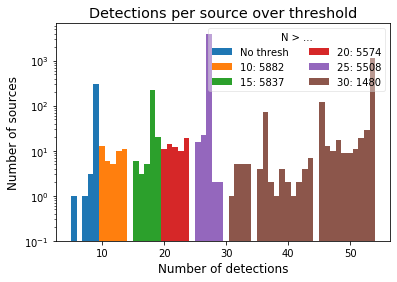

In [32]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Detections per source over threshold")
ax.set_xlabel("Number of detections")
ax.set_ylabel("Number of sources")

hist_args = {'log':True, 'histtype':'stepfilled'}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(ndet.groupby('NMAST')['n'].sum(),
               bins=ndet.groupby('NMAST')['n'].sum().max(),
               label='No thresh',
               **full_hist_args)

# plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}: {len(obj_ids)}"
    ndet_cut = ndet[ndet['NMAST'].isin(obj_ids)]
    ax.hist(ndet_cut.groupby('NMAST')['n'].sum(),
            bins=hist[1],
            label=label,
            **hist_args)

ax.legend(ncol=2, loc='upper right', framealpha=0.4, title='N > ...')

if False:
    fig.savefig(figpath / "detection_threshold_distro.png")

As could be expected, the shape of the distribution is unaffected; only the lower limit changes.

## Changes to q

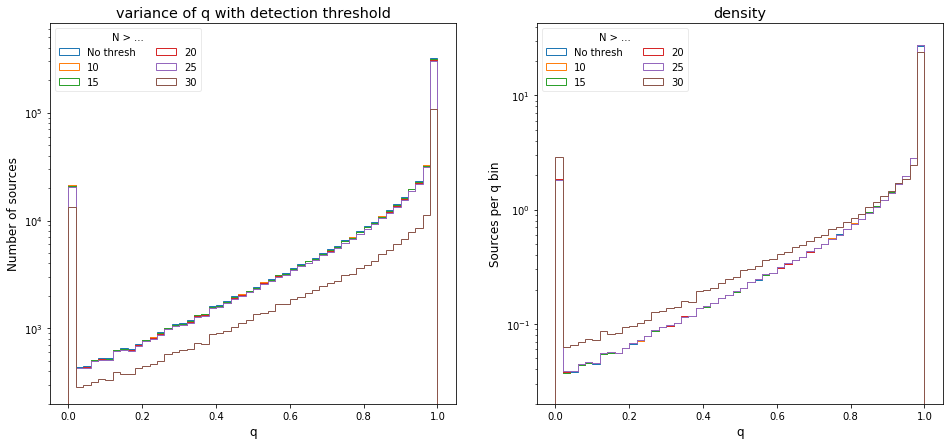

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

ax = axes[0]
ax.set_title("variance of q with detection threshold")
ax.set_xlabel("q")
ax.set_ylabel("Number of sources")

hist_args = {'log':True, 'histtype':'step', 'density':False}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(ps_cat[['q1','q2','q3']].values.ravel(),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat[ps_cat['NMAST'].isin(obj_ids)]
    ax.hist(ps_cat_cut[['q1','q2','q3']].values.ravel(),
            bins=hist[1],
            label=label,
            **hist_args)
ax.set_ylim(2e2)
ax.legend(ncol=2, loc='upper left', framealpha=0.4, title='N > ...')


ax = axes[1]
ax.set_title("density")
ax.set_xlabel("q")
ax.set_ylabel("Sources per q bin")

hist_args = {'log':True, 'histtype':'step', 'density':True}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(ps_cat[['q1','q2','q3']].values.ravel(),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat[ps_cat['NMAST'].isin(obj_ids)]
    ax.hist(ps_cat_cut[['q1','q2','q3']].values.ravel(),
            bins=hist[1],
            label=label,
            **hist_args)
ax.set_ylim(2e-2)
ax.legend(ncol=2, loc='upper left', framealpha=0.4, title='N > ...')

if False:
    fig.savefig(figpath / "q_vs_detection_threshold.png")


The cut seems to have a pretty even effect across q, with a bunch of q=0 sources still remaining

## Changes to z

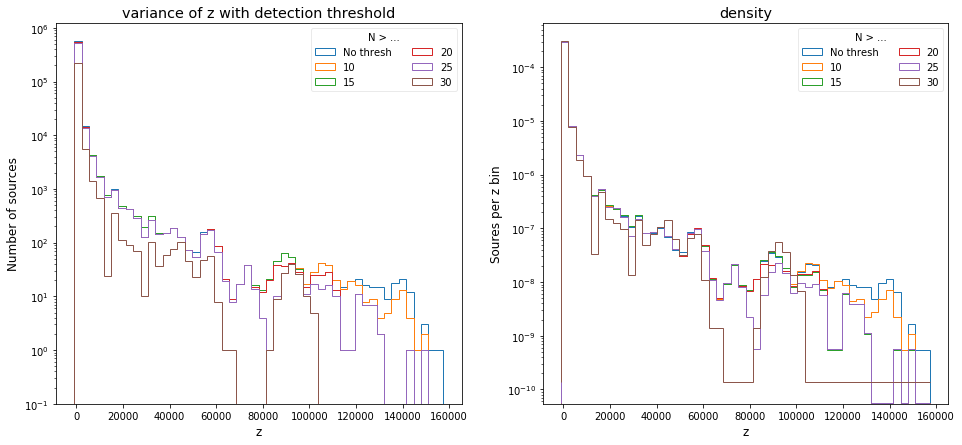

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

ax = axes[0]
ax.set_title("variance of z with detection threshold")
ax.set_xlabel("z")
ax.set_ylabel("Number of sources")

hist_args = {'log':True, 'histtype':'step', 'density':False}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(ps_cat[['z1','z2','z3']].values.ravel(),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat[ps_cat['NMAST'].isin(obj_ids)]
    ax.hist(ps_cat_cut[['z1','z2','z3']].values.ravel(),
            bins=hist[1],
            label=label,
            **hist_args)
# ax.set_ylim(1e-2)
ax.legend(ncol=2, loc='upper right', framealpha=0.4, title='N > ...')

ax = axes[1]
ax.set_title("density")
ax.set_xlabel("z")
ax.set_ylabel("Soures per z bin")

hist_args = {'log':True, 'histtype':'step', 'density':True}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(ps_cat[['z1','z2','z3']].values.ravel(),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat[ps_cat['NMAST'].isin(obj_ids)]
    ax.hist(ps_cat_cut[['z1','z2','z3']].values.ravel(),
            bins=hist[1],
            label=label,
            **hist_args)
# ax.set_ylim(1e-2)
ax.legend(ncol=2, loc='upper right', framealpha=0.4, title='N > ...')

if False:
    fig.savefig(figpath / "z_vs_detection_threshold.png")


### Cut out z <= 0 so you can do log(z) 
(and also cut q == 0)

In [25]:
query = ' and '.join([f"z{i} > 0" for i in ks2_utils.phot_method_ids])
query += 'and ' + ' and '.join([f"q{i} > 0" for i in ks2_utils.phot_method_ids])
ps_cat_no0 = ps_cat.query(query)

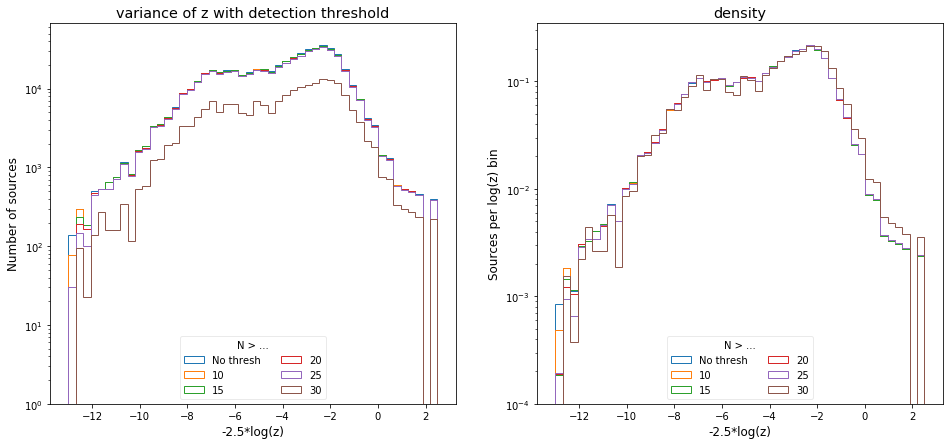

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

ax = axes[0]
ax.set_title("variance of z with detection threshold")
ax.set_xlabel("-2.5*log(z)")
ax.set_ylabel("Number of sources")

hist_args = {'log':True, 'histtype':'step', 'density':False}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(-2.5*np.log10(ps_cat_no0[['z1','z2','z3']].values.ravel()),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat_no0[ps_cat_no0['NMAST'].isin(obj_ids)]
    ax.hist(-2.5*np.log10(ps_cat_cut[['z1','z2','z3']].values.ravel()),
            bins=hist[1],
            label=label,
            **hist_args)

ax.set_ylim(1e0)
ax.legend(ncol=2, loc='lower center', framealpha=0.4, title='N > ...')

ax = axes[1]
ax.set_title("density")
ax.set_xlabel("-2.5*log(z)")
ax.set_ylabel("Sources per log(z) bin")

hist_args = {'log':True, 'histtype':'step', 'density':True}

# number of detections in either filter
full_hist_args = hist_args.copy()
# full_hist_args['histtype'] = 'stepfilled'
# full_hist_args['alpha'] = 0.5
hist = ax.hist(-2.5*np.log10(ps_cat_no0[['z1','z2','z3']].values.ravel()),
               bins=50,
               label='No thresh',
               **full_hist_args)

# # plot the number of detections in each filter separately
for thresh, obj_ids in n_thresh.items():
    label = f"{thresh}"
    ps_cat_cut = ps_cat_no0[ps_cat_no0['NMAST'].isin(obj_ids)]
    ax.hist(-2.5*np.log10(ps_cat_cut[['z1','z2','z3']].values.ravel()),
            bins=hist[1],
            label=label,
            **hist_args)

ax.set_ylim(1e-4)
ax.legend(ncol=2, loc='lower center', framealpha=0.4, title='N > ...')

if False:
    fig.savefig(figpath / "logz_vs_detection_threshold.png")


## Full-frame images

In [51]:
exp_gb = ps_cat.groupby("exp_id")
file_ind = 50
file_id = list(exp_gb.groups)[file_ind]
img = fits.getdata(shared_utils.get_data_file(ks2_utils.get_file_name_from_ks2id(file_id)), 1)
img[img<=0] = np.nan
img = np.log10(img)

In [52]:
# first, select the chosen exposure
exp_df = ps_cat_no0.query(f"exp_id == '{file_id}'")
n_det_dfs = {thresh: exp_df[exp_df['NMAST'].isin(obj_ids)]
             for thresh, obj_ids in n_thresh.items()}

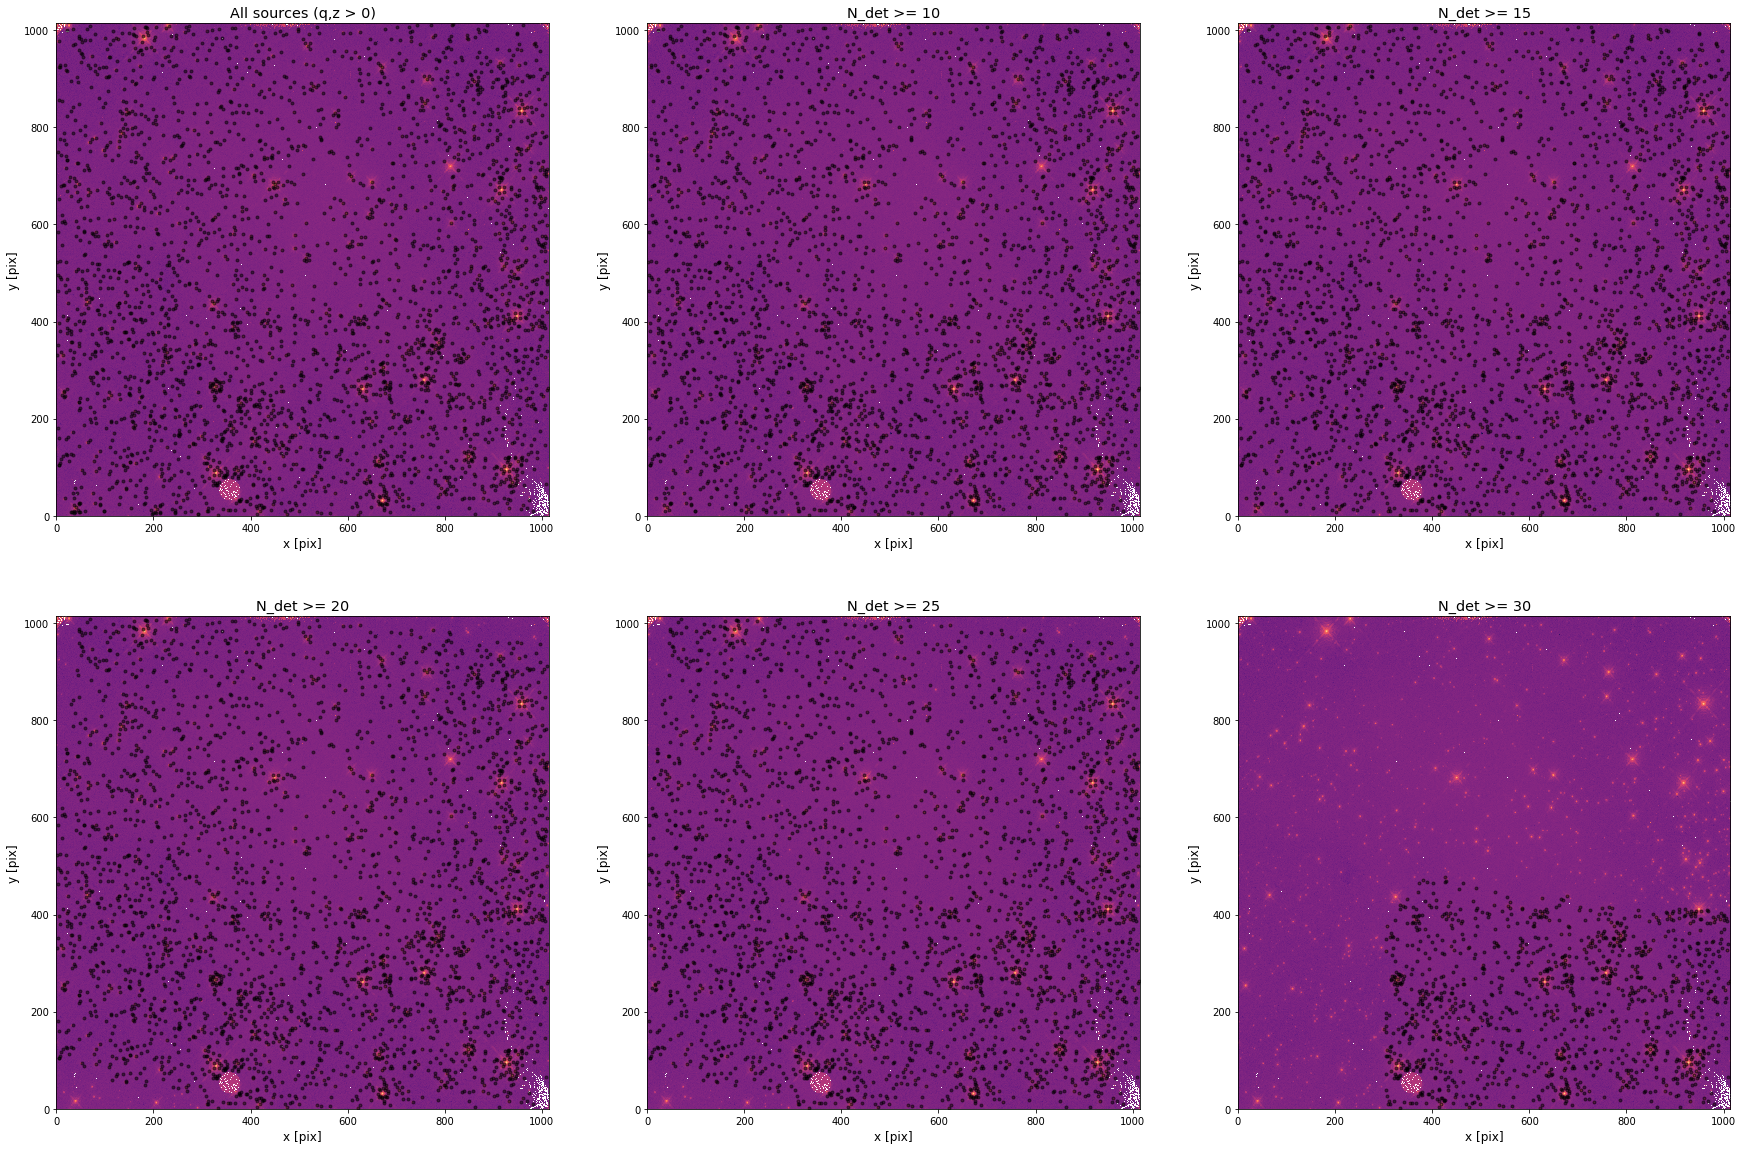

In [53]:
ncols = 3
nrows = np.int(np.ceil((len(n_det_dfs.keys())+1)/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# fig.suptitle(f"{file_id}")

for ax in axes.ravel():
    ax.set_xlabel("x [pix]")
    ax.set_ylabel("y [pix]")

img_args = {#'norm':mpl.colors.LogNorm(),
            'cmap':mpl.cm.magma}
marker_color='k'

ax = axes[0, 0]
ax.set_title("All sources (q,z > 0)")
ax.imshow(img, **img_args)
ax.scatter(exp_df['xraw1'],
           exp_df['yraw1'],
           marker='.', color=marker_color, alpha=0.5)

for i, thresh in enumerate(sorted(n_det_dfs.keys())):
    ax = axes.ravel()[i+1]
    ax.set_title(f"N_det >= {thresh}")
    ax.imshow(img, **img_args)
    ax.scatter(n_det_dfs[thresh]['xraw1'],
               n_det_dfs[thresh]['yraw1'],
               marker='.', color=marker_color, alpha=0.5)

for ax in axes.ravel():
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(0, img.shape[0])

if False:
    fig.savefig(figpath / "fullframe-ndet_cuts-qz_gt_0.png")

# Which sources are the ones being cut?

In [65]:
thresh=10
cut_df = n_det_dfs[thresh]

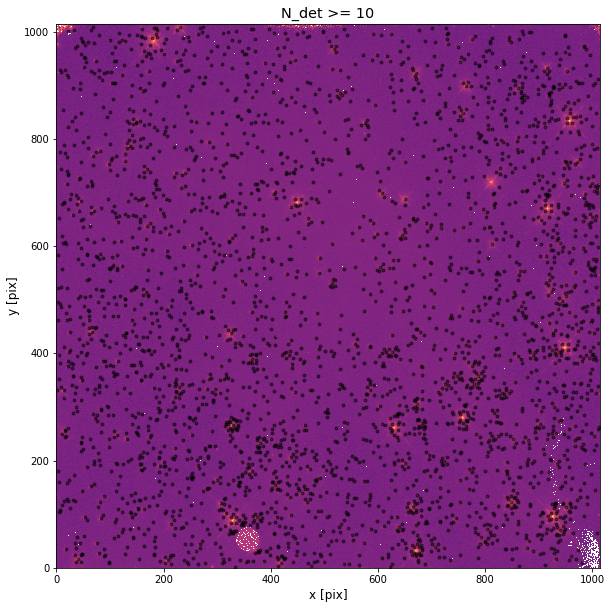

In [69]:
nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# fig.suptitle(f"{file_id}")

ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")

img_args = {#'norm':mpl.colors.LogNorm(),
            'cmap':mpl.cm.magma}
marker_color='k'

# ax = axes[0, 0]
# ax.set_title("All sources (q,z > 0)")
# ax.imshow(img, **img_args)
# ax.scatter(exp_df['xraw1'],
#            exp_df['yraw1'],
#            marker='.', color=marker_color, alpha=0.5)

# for i, thresh in enumerate(sorted(n_det_dfs.keys())):
#     ax = axes.ravel()[i+1]
ax.set_title(f"N_det >= {thresh}")
ax.imshow(img, **img_args)
ax.scatter(n_det_dfs[thresh]['xraw1'],
           n_det_dfs[thresh]['yraw1'],
           marker='.', color=marker_color, alpha=0.5)

ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])

if True:
    fig.savefig(figpath / f"fullframe-ndet_gt_{thresh}-qz_gt_0.png")

In [319]:
thresh = 20
obj_ids = n_thresh[thresh]
ps_cat_cut = ps_cat[ps_cat['NMAST'].isin(obj_ids)]

In [320]:
ps_cat_cut.shape

(186565, 42)

# Check out stars that got cut

In [321]:
lodet_cat = ps_cat[~ps_cat['NMAST'].isin(obj_ids)]

In [322]:
# choose a star at random
import random

In [364]:
star_id = random.choice(lodet_cat['NMAST'].values)
star_df = lodet_cat.query("NMAST == @star_id")

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


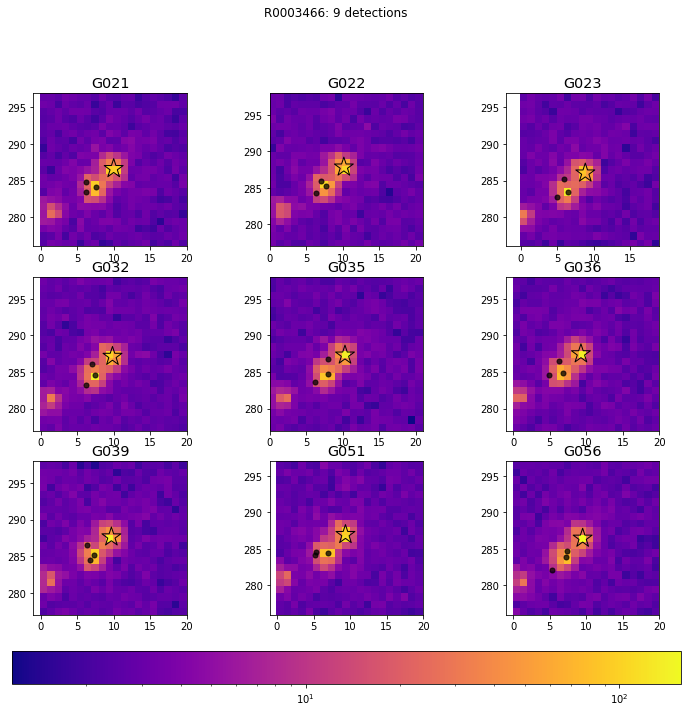

In [365]:
stamp_rad = 21

ncols = 3
nrows = np.int(np.ceil(len(star_df)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
fig.suptitle(f"{star_id}: {len(star_df)} detections")


img_args = {'cmap':mpl.cm.plasma}#, 'norm':mpl.colors.LogNorm(vmin=img_min, vmax=img_max)}
img_min, img_max = np.inf, -np.inf
for i, row in star_df.reset_index().iterrows():
    img, yx = image_utils.get_stamp_from_ks2(row, stamp_rad, True)
    img[img <= 0] = np.nan
    img_min = np.nanmin([img_min, np.nanmin(img)])
    img_max = np.nanmax([img_max, np.nanmax(img)])
    neighbors = ks2_utils.get_exposure_neighbors(ps_cat, star_id, row['exp_id'], stamp_rad/2)

    ax = axes.ravel()[i]
    ax.set_title(f"{row['exp_id']}")
    # adjust x and y for use with pcolor
    y = list(yx[0]) + [yx[0][-1]+1]
    x = list(yx[1]) + [yx[1][-1]+1]
    imax = ax.pcolor(x, y, img, **img_args)
    ax.scatter(row['xraw1']-0.5, row['yraw1']-0.5, 
               marker='*', ec='k', color='none', s=400)
    for n, nrow in neighbors.iterrows():
        ax.scatter(nrow['xraw1']-0.5, nrow['yraw1']-0.5, marker='.', color='k', s=100, alpha=0.75)

# formating    
for ax in axes.flat[:len(star_df)]:
    # color scale
    imax = ax.get_children()[0]
    imax.set_norm(mpl.colors.LogNorm(vmin=img_min, vmax=img_max))
    # labels
#     ax.label_outer()
    # aspect ratio
    ax.set_aspect('equal')

# turn off extra axes
for ax in axes.ravel()[len(star_df):]:
    ax.set_visible(False)
    
# plot a shared colorbar
plt.colorbar(imax, ax=axes.ravel(), orientation='horizontal', pad=0.05, anchor=(0.5, 0.95))

In [355]:
nrow['xraw1']

1008.53

In [250]:
reload(ks2_utils)
dist = ks2_utils.calc_exp_dist_from_obj(exp_df, obj_id)

In [251]:
#dist_mat = ks2_utils.generate_exposure_distance_matrix(exp_df)

In [254]:
dist[dist < 11]

NMAST
R0003540    9.803073
R0003544    9.139762
R0003556    9.180856
dtype: float64

In [256]:
dist[dist < 11].index

Index(['R0003540', 'R0003544', 'R0003556'], dtype='object', name='NMAST')

In [258]:
neighbors = dist.index[dist < 11]

In [259]:
exp_df[exp_df['NMAST'].isin(neighbors)]

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,exp_id,filt_id,unk,chip_id
108014,221.307,943.551,-7.9141,0.0,0.0,1462.2,1.8,0,1,201.615,...,9.5,1,1,R0003540,L038,N015,G032,F2,C,1
108122,238.191,951.379,-3.2741,0.0,0.0,19.1,0.7,0,1,235.382,...,0.6,1,1,R0003544,L043,N015,G032,F2,C,1
108446,220.500,945.087,-4.8837,0.0,0.0,85.1,1.4,0,1,200.000,...,111.9,1,1,R0003556,L073,N015,G032,F2,C,1
